In [22]:
!pip install wandb -qU


In [3]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("WANDB") 

wandb.login(key=my_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vtuan36420 (vtuan36420-asana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ========== CÀI ĐẶT WANDB ==========
wandb.init(
    project="vietnamese-food-classification",
    name="efficientnet_b0_30epoch",
    config={
        "model": "efficientnet_b0",
        "epochs": 30,
        "batch_size": 32,
        "lr": 1e-4,
        "optimizer": "Adam",
        "scheduler": "ReduceLROnPlateau",
        "num_classes": 30,
        "dataset_source": "https://www.kaggle.com/datasets/quandang/vietnamese-foods",
    }
)

# Đường dẫn gốc
root_input = "/kaggle/input/vietnamese-foods/Images"
combined_dir = "/kaggle/working/combined"
output_dir = "/kaggle/working/split"  # Chia ra train/val/test ở đây

# Bước 1: Gộp lại toàn bộ ảnh từ Train/Validate/Test vào combined_dir
os.makedirs(combined_dir, exist_ok=True)

for split in ['Train', 'Validate', 'Test']:
    split_path = os.path.join(root_input, split)
    for food_class in os.listdir(split_path):
        class_path = os.path.join(split_path, food_class)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            src = os.path.join(class_path, img_file)
            dst_dir = os.path.join(combined_dir, food_class)
            os.makedirs(dst_dir, exist_ok=True)
            dst = os.path.join(dst_dir, f"{split}_{img_file}")
            shutil.copy(src, dst)

# Bước 2: Chia theo tỉ lệ 70/15/15
for food_class in tqdm(os.listdir(combined_dir), desc="Splitting classes"):
    class_dir = os.path.join(combined_dir, food_class)
    images = os.listdir(class_dir)

    if len(images) < 10:
        print(f"❗ Bỏ qua lớp {food_class} vì quá ít ảnh ({len(images)})")
        continue

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, img_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(output_dir, split, food_class)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in img_list:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy(src, dst)

print("✅ Hoàn tất chia lại dữ liệu theo tỉ lệ 70/15/15.")

Splitting classes: 100%|██████████| 30/30 [00:06<00:00,  4.64it/s]

✅ Hoàn tất chia lại dữ liệu theo tỉ lệ 70/15/15.


In [5]:
import zipfile

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                abs_path = os.path.join(root, file)
                rel_path = os.path.relpath(abs_path, folder_path)
                zf.write(abs_path, rel_path)

zip_output_path = "/kaggle/working/split_dataset.zip"
zip_folder(output_dir, zip_output_path)
print(f"✅ Đã nén dữ liệu chia tỉ lệ vào: {zip_output_path}")

✅ Đã nén dữ liệu chia tỉ lệ vào: /kaggle/working/split_dataset.zip


In [6]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.transforms import ColorJitter, GaussianBlur
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===================== SETUP =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/working/split"
num_classes = 30
batch_size = 32
epochs = 30

📊 Tổng số ảnh: 25136
Train set: 17583 ảnh
Val set: 3769 ảnh
Test set: 3784 ảnh


/tmp/ipykernel_35/3725355162.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3725355162.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


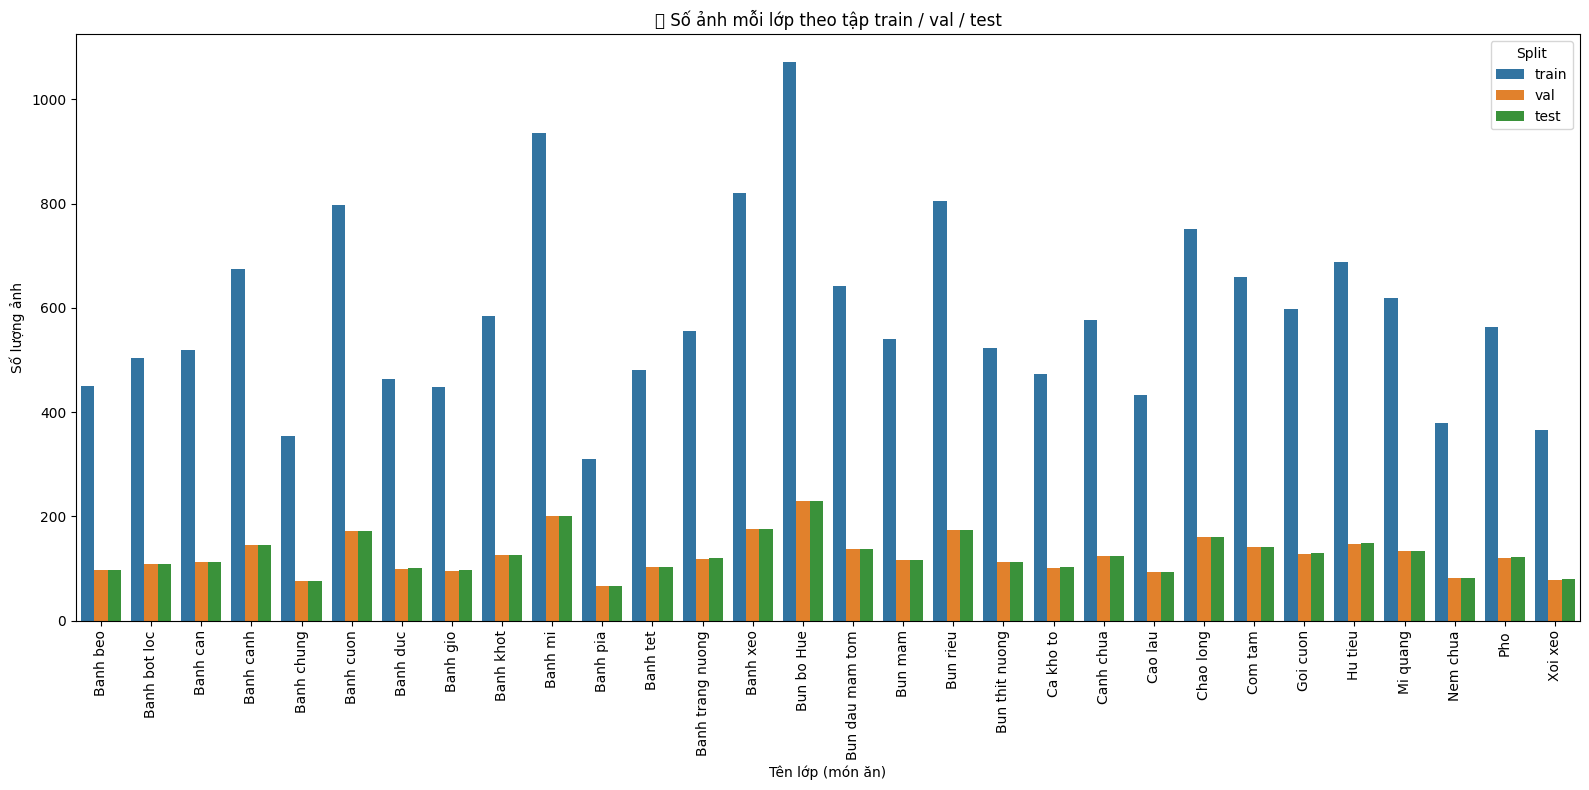

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Đường dẫn đến các folder
splits = ['train', 'val', 'test']
split_paths = {split: os.path.join(data_dir, split) for split in splits}

# Đếm số lượng ảnh trong mỗi class
split_counts = {}
total_images = 0

for split, path in split_paths.items():
    class_counts = {}
    for class_name in sorted(os.listdir(path)):
        class_folder = os.path.join(path, class_name)
        if os.path.isdir(class_folder):
            count = len(os.listdir(class_folder))
            class_counts[class_name] = count
            total_images += count
    split_counts[split] = class_counts

# Thống kê tổng
print("📊 Tổng số ảnh:", total_images)
for split in splits:
    split_total = sum(split_counts[split].values())
    print(f"{split.capitalize()} set: {split_total} ảnh")

# Tạo DataFrame để dễ xử lý với seaborn
df_list = []
for split in splits:
    for class_name, count in split_counts[split].items():
        df_list.append({
            "Class": class_name,
            "Split": split,
            "Count": count
        })

df = pd.DataFrame(df_list)

# Vẽ biểu đồ phần trăm theo split
plt.figure(figsize=(16, 8))
sns.barplot(data=df, x="Class", y="Count", hue="Split")
plt.xticks(rotation=90)
plt.title("📊 Số ảnh mỗi lớp theo tập train / val / test")
plt.ylabel("Số lượng ảnh")
plt.xlabel("Tên lớp (món ăn)")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Log hình ảnh biểu đồ lên wandb
wandb.log({"class_distribution": wandb.Image("class_distribution.png")})

In [8]:
# ===================== TRANSFORMS =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomApply([GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [9]:
# ===================== DATALOADERS =====================
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transform)
test_set = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [10]:
# ===================== MODEL =====================
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_l

Epoch 1/30


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


✅ Train Loss: 2.0699, Acc: 0.4578 | Val Loss: 0.9187, Acc: 0.7384
🔥 Best model saved with val acc: 0.7384
Epoch 2/30


✅ Train Loss: 1.0588, Acc: 0.6983 | Val Loss: 0.6454, Acc: 0.8079
🔥 Best model saved with val acc: 0.8079
Epoch 3/30


✅ Train Loss: 0.8688, Acc: 0.7479 | Val Loss: 0.5506, Acc: 0.8389
🔥 Best model saved with val acc: 0.8389
Epoch 4/30


✅ Train Loss: 0.7610, Acc: 0.7789 | Val Loss: 0.5075, Acc: 0.8535
🔥 Best model saved with val acc: 0.8535
Epoch 5/30


✅ Train Loss: 0.6880, Acc: 0.8000 | Val Loss: 0.4696, Acc: 0.8612
🔥 Best model saved with val acc: 0.8612
Epoch 6/30


✅ Train Loss: 0.6346, Acc: 0.8142 | Val Loss: 0.4598, Acc: 0.8718
🔥 Best model saved with val acc: 0.8718
Epoch 7/30


✅ Train Loss: 0.5776, Acc: 0.8285 | Val Loss: 0.4412, Acc: 0.8748
🔥 Best model saved with val acc: 0.8748
Epoch 8/30


✅ Train Loss: 0.5565, Acc: 0.8346 | Val Loss: 0.4453, Acc: 0.8758
🔥 Best model saved with val acc: 0.8758
Epoch 9/30


✅ Train Loss: 0.5396, Acc: 0.8394 | Val Loss: 0.4462, Acc: 0.8764
🔥 Best model saved with val acc: 0.8764
Epoch 10/30


✅ Train Loss: 0.5052, Acc: 0.8485 | Val Loss: 0.4316, Acc: 0.8795
🔥 Best model saved with val acc: 0.8795
Epoch 11/30


✅ Train Loss: 0.4709, Acc: 0.8623 | Val Loss: 0.4374, Acc: 0.8764
⏳ No improvement. EarlyStopping counter: 1/5
Epoch 12/30


✅ Train Loss: 0.4486, Acc: 0.8650 | Val Loss: 0.4362, Acc: 0.8801
🔥 Best model saved with val acc: 0.8801
Epoch 13/30


✅ Train Loss: 0.4277, Acc: 0.8715 | Val Loss: 0.4436, Acc: 0.8785
⏳ No improvement. EarlyStopping counter: 1/5
Epoch 14/30


✅ Train Loss: 0.4126, Acc: 0.8783 | Val Loss: 0.4447, Acc: 0.8851
🔥 Best model saved with val acc: 0.8851
Epoch 15/30


✅ Train Loss: 0.4084, Acc: 0.8816 | Val Loss: 0.4326, Acc: 0.8835
⏳ No improvement. EarlyStopping counter: 1/5
Epoch 16/30


✅ Train Loss: 0.3858, Acc: 0.8853 | Val Loss: 0.4487, Acc: 0.8864
🔥 Best model saved with val acc: 0.8864
Epoch 17/30


✅ Train Loss: 0.3749, Acc: 0.8873 | Val Loss: 0.4643, Acc: 0.8822
⏳ No improvement. EarlyStopping counter: 1/5
Epoch 18/30


✅ Train Loss: 0.3701, Acc: 0.8897 | Val Loss: 0.4424, Acc: 0.8859
⏳ No improvement. EarlyStopping counter: 2/5
Epoch 19/30


✅ Train Loss: 0.3609, Acc: 0.8903 | Val Loss: 0.4531, Acc: 0.8806
⏳ No improvement. EarlyStopping counter: 3/5
Epoch 20/30


✅ Train Loss: 0.3245, Acc: 0.9059 | Val Loss: 0.4378, Acc: 0.8856
⏳ No improvement. EarlyStopping counter: 4/5
Epoch 21/30


✅ Train Loss: 0.3110, Acc: 0.9081 | Val Loss: 0.4528, Acc: 0.8822
⏳ No improvement. EarlyStopping counter: 5/5
🛑 Early stopping triggered.


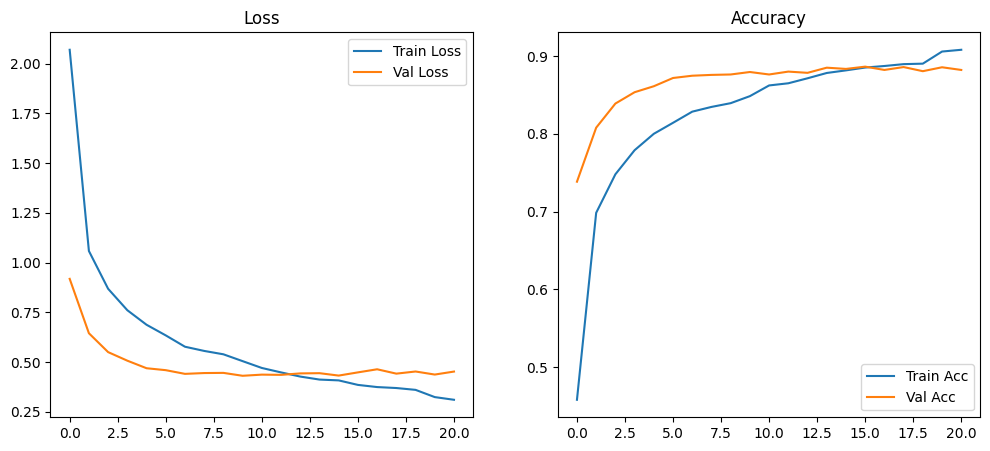

In [11]:
# ===================== TRAIN LOOP =====================
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_acc = 0.0
patience = 5         # số epoch cho phép không cải thiện
counter = 0          # đếm số epoch không cải thiện
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    model.train()
    running_loss, running_correct = 0.0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct += (preds == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_correct / len(train_set)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    # ==== VALIDATION ====
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_set)
    val_acc = val_correct / len(val_set)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"✅ Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    # Log metrics lên wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "train_acc": epoch_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

    # Cập nhật lr scheduler
    scheduler.step(val_acc)

    # ==== Save best ====
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/checkpoints/best_model.pth")
        print(f"🔥 Best model saved with val acc: {val_acc:.4f}")
        wandb.save("/kaggle/working/checkpoints/best_model.pth")
    else:
        counter += 1
        print(f"⏳ No improvement. EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break

# ===================== PLOT =====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load("/kaggle/working/checkpoints/best_model.pth"))
model.eval()

test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / len(test_set)
print(f"🎯 Final Test Accuracy: {test_acc:.4f}")
wandb.log({"test_accuracy": test_acc})

Testing: 100%|██████████| 119/119 [00:57<00:00,  2.08it/s]

🎯 Final Test Accuracy: 0.8805


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json


# Sau khi đã có y_true, y_pred
class_names = train_set.classes
print("📊 Classification Report:")
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Log weighted avg metrics
wandb.log({
    "test_precision": report_dict["weighted avg"]["precision"],
    "test_recall": report_dict["weighted avg"]["recall"],
    "test_f1": report_dict["weighted avg"]["f1-score"]
})

# Lưu classification report dưới dạng JSON
with open("classification_report.json", "w") as f:
    json.dump(report_dict, f, indent=4)

# Log file JSON vào WandB
wandb.save("classification_report.json")

# render classification report thành ảnh

df_report = pd.DataFrame(report_dict).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.tight_layout()

report_img_path = "classification_report.png"
plt.savefig(report_img_path, dpi=300)
wandb.log({"classification_report_image": wandb.Image(report_img_path)})
wandb.save(report_img_path)
plt.close()

wandb.finish()

📊 Classification Report:
                  precision    recall  f1-score   support

        Banh beo       0.84      0.95      0.89        97
    Banh bot loc       0.90      0.81      0.85       108
        Banh can       0.90      0.93      0.91       112
       Banh canh       0.72      0.66      0.69       145
      Banh chung       0.81      0.88      0.84        76
       Banh cuon       0.90      0.85      0.88       171
        Banh duc       0.83      0.70      0.76       100
        Banh gio       0.83      0.94      0.88        97
       Banh khot       0.93      0.96      0.95       126
         Banh mi       0.93      0.97      0.95       201
        Banh pia       1.00      0.94      0.97        67
        Banh tet       0.91      0.83      0.87       103
Banh trang nuong       0.90      0.95      0.93       120
        Banh xeo       0.96      0.89      0.92       176
      Bun bo Hue       0.83      0.85      0.84       230
 Bun dau mam tom       0.98      1.00      0.9

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_f1,▁▁
test_precision,▁▁
test_recall,▁▁
train_acc,▁▅▆▆▆▇▇▇▇▇▇▇▇████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇█████████████
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
test_accuracy,0.88055
